In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln, digamma, logsumexp
cmap = plt.get_cmap('tab10')

In [2]:
N = 150
K = 3

lam_model = np.array([1,10,18])
phi_model = np.array([0.3,0.4,0.3])

S_true = np.random.multinomial(n=1, pvals=phi_model, size=N)
label_true = np.argmax(S_true, 1)
X_obs = np.array([np.random.poisson(lam=lam_model[i]) for i in label_true])

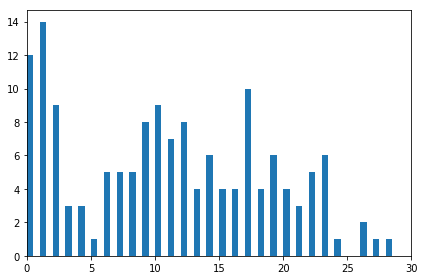

In [3]:
plt.figure(figsize=(6,4))
plt.hist(X_obs, bins=60, range=(0,30))
plt.xlim(0,30)
plt.tight_layout()

In [4]:
def update_parameter(X, Z, prior):
    a_pri, b_pri, alpha_pri = prior
    _, K = Z.shape
    
    a_post = np.dot(X, Z) + a_pri
    b_post = np.sum(Z, 0) + b_pri
    alpha_post = np.sum(Z, 0) + alpha_pri
    
    return [a_post, b_post, alpha_post]

def sample_PMM(posterior):
    a_post, b_post, _ = posterior
    
    lam = np.array([np.random.gamma(a, 1/b) for a, b in zip(a_post, b_post)])
    
    return [lam]

def get_cavity(n, Z, pmm):
    lam = pmm[0]
    
    n_samples = np.sum(Z, 0) - Z[n]
    mask = np.where(n_samples != 0)[0]
    lam_cav = lam[mask]
    Z_cav = Z[:,mask]
    
    return Z_cav, [lam_cav]

def sample_Zn(x, Z_cav, pmm_cav, prior):
    a_pri, b_pri, alpha_pri = prior
    lam = pmm_cav[0]
    N, K = Z_cav.shape
    
    num_cav = np.sum(Z_cav, 0)
    p = 1 / (1 + b_pri)
    
    ln_tmp = np.zeros(K+1)
    for k in range(K+1):
        if k < K:
            ln_tmp[k] = x * np.log(lam[k]) - lam[k] - gammaln(x+1) + np.log(num_cav[k]/(N+alpha_pri))
        else:
            ln_tmp[k] = ( a_pri * np.log(1-p) + x * np.log(p) 
                         - gammaln(x+1) + gammaln(x+a_pri) - gammaln(a_pri) 
                         + np.log(alpha_pri/(N+alpha_pri)) )
    ln_tmp -= logsumexp(ln_tmp)
    Zn = np.random.multinomial(n=1, pvals=np.exp(ln_tmp))
    
    return Zn

def interpolate(n, Z, Zn):
    label = np.argmax(Z, 1)
    label[n] = np.argmax(Zn)
    
    K = max(label) + 1
    Z = np.eye(K)[label]
    
    n_samples = np.sum(Z, 0)
    mask = np.where(n_samples != 0)[0]
    
    return Z[:,mask]

def sample_Z_DP_GS(X, Z, posterior, prior):
    N = len(X)
    
    for n in np.random.permutation(N):
        pmm = sample_PMM(posterior)
        Z_cav, pmm_cav = get_cavity(n, Z, pmm)
        Zn = sample_Zn(X[n], Z_cav, pmm_cav, prior)
        Z = interpolate(n, Z, Zn)
        posterior = update_parameter(X, Z, prior)
    
    return Z, posterior

def calc_expt_ln_map(X, Z, prior, posterior):
    a_pri, b_pri, alpha_pri = prior
    a_post, b_post, _ = posterior
    N, K = Z.shape
    
    expt_lam = a_post / b_post
    expt_ln_lam = digamma(a_post) - np.log(b_post)
    
    expt_ln_lkh = 0.0
    for n in range(N):
        tmp = X[n] * expt_ln_lam - expt_lam - gammaln(X[n]+1)
        expt_ln_lkh += np.dot(Z[n], tmp)
    
    expt_ln_plam = 0.0
    for k in range(K):
        expt_ln_plam += (a_pri - 1) * expt_ln_lam[k] - b_pri * expt_lam[k] + a_pri * np.log(b_pri) - gammaln(a_pri)
    
    expt_ln_ps = K * np.log(alpha_pri) + np.sum(gammaln(np.sum(Z, 0))) - gammaln(N+alpha_pri) + gammaln(alpha_pri)
    
    return expt_ln_lkh + expt_ln_plam + expt_ln_ps

def train(X, K, prior, max_iter=100):
    N = len(X)
    
    posterior_list = []
    label_list = []
    expt_ln_map = []
    
    Z = np.random.dirichlet(alpha=np.ones(K)/K, size=N)
    posterior = update_parameter(X, Z, prior)
    for i in range(max_iter):
        Z, posterior = sample_Z_DP_GS(X, Z, posterior, prior)
        posterior_list.append(posterior)
        label_list.append(np.argmax(Z, 1))
        expt_ln_map.append(calc_expt_ln_map(X, Z, prior, posterior))
    
    return posterior_list, label_list, expt_ln_map

def predict(x, posterior):
    a_post, b_post, alpha_post = posterior
    
    a_pred = x + a_post
    b_pred = 1 + b_post
    alpha_pred = 1 + alpha_post
    
    p_pred = 1 / (1 + b_pred)
    phi_pred = alpha_pred / np.sum(alpha_pred)
    ln_tmp = a_pred * np.log(1 - p_pred) + x * np.log(p_pred) + gammaln(x + a_pred) - gammaln(a_pred) - gammaln(x + 1) + np.log(phi_pred)
    ln_tmp -= logsumexp(ln_tmp)
    
    return np.exp(ln_tmp)

In [5]:
max_iter = 100
K_init = 1
a_init = 1.0
b_init = 0.01
alpha_init = 1.0
prior = [a_init, b_init, alpha_init]

posterior, label, expt_ln_map = train(X_obs, K_init, prior, max_iter)

In [6]:
num_list = np.zeros(max_iter)
for i in range(max_iter):
    num_list[i] = max(label[i]) + 1

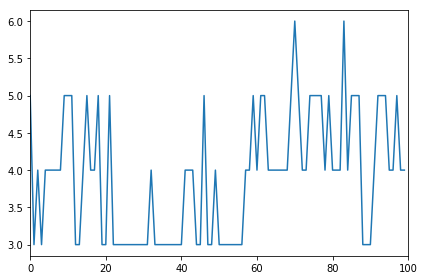

In [7]:
plt.figure(figsize=(6,4))
plt.plot(num_list)
plt.xlim(0, max_iter)
plt.tight_layout()

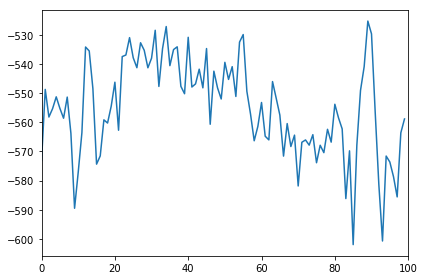

In [8]:
plt.figure(figsize=(6,4))
plt.plot(expt_ln_map)
plt.xlim(0, max_iter)
plt.tight_layout()

In [9]:
idx = np.argmax(expt_ln_map)

X = np.arange(0,80,0.1)
Z_pred = np.array([predict(x, posterior[idx]) for x in X])

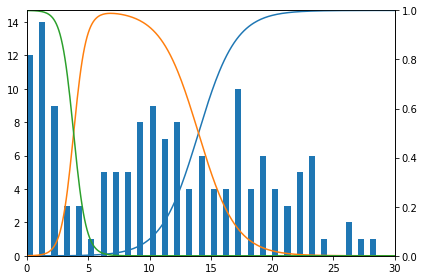

In [10]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
ax1.hist(X_obs, bins=60, range=(0,30))
ax1.set_xlim(0,30)

ax2 = ax1.twinx()
for k in range(Z_pred.shape[1]):
    ax2.plot(X, Z_pred[:,k])
ax2.set_xlim(0,30)
ax2.set_ylim(0,1)

plt.tight_layout()